In [1]:
import pandas as pd
import altair as alt
import numpy as np
import datetime
from datetime import timedelta
from scipy.stats import zscore
from IPython import display, html

from src.mayer_multiple.compute_metrics import compute_mm_metrics_for_ticker, format_message

/Users/olshansky/.pyenv/versions/3.7.7/envs/market_navigator_env/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df_full = pd.read_feather('/Users/olshansky/workspace/tip/daily_data.feather')
df_full.set_index('date')
df_full.index = pd.to_datetime(df_full['date'])
df_full = df_full.sort_index()
df_full

,ticker,date,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps,price
date,,,,,,,,,,,
2011-01-03,MHRCQ,2011-01-03,2021-05-30,482.6,-30.4,-65.7,430.2,6.2,-19.8,14.0,7.420
2011-01-03,FFDF,2011-01-03,2019-12-13,20.7,11.3,9.0,14.4,0.8,12.0,2.0,10.073
2011-01-03,FFEX,2011-01-03,2018-10-18,79.4,-3.9,-3053.8,81.6,1.0,-6.3,0.2,4.660
2011-01-03,FFFD,2011-01-03,2018-10-18,50.9,17.2,12.1,22.6,0.5,13.7,1.2,16.618
2011-01-03,FFG,2011-01-03,2018-10-18,1227.9,7.2,7.0,911.9,0.8,9.1,0.9,19.087
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28,NGG,2021-05-28,2021-05-28,89444.2,24.3,15.5,50556.9,2.0,31.6,2.7,66.870
2021-05-28,NGL,2021-05-28,2021-05-28,3734.4,-7.9,-27.8,308.7,0.3,-0.4,0.1,2.390
2021-05-28,NGM,2021-05-28,2021-05-28,1010.3,-9.1,-9.7,1159.9,2.9,-10.5,NaN,15.060


In [3]:
window = 200    
ticker = 'GOOGL'
df = compute_mm_metrics_for_ticker(df_full, ticker, window)
df

,price,price_roll_avg_200,mayer_multiple,mm_z_score,freq_gt
date,,,,,
2011-01-03,302.477,NaN,NaN,NaN,NaN
2011-01-04,301.361,NaN,NaN,NaN,NaN
2011-01-05,304.840,NaN,NaN,NaN,NaN
2011-01-06,307.057,NaN,NaN,NaN,NaN
2011-01-07,308.529,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-05-24,2361.040,1853.85900,1.273581,0.996988,1.491966
2021-05-25,2362.870,1858.18150,1.271603,0.962518,1.529637
2021-05-26,2380.310,1862.59895,1.277951,1.031948,1.414373


<AxesSubplot:xlabel='date'>

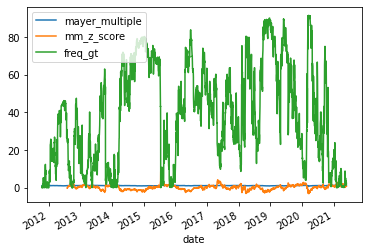

In [4]:
df[['mayer_multiple', 'mm_z_score', 'freq_gt']].plot()

In [5]:
# Compute binned data

def _bin_data(df: pd.DataFrame, bin_size: float = 0.05):
    bins = np.arange(0, 3, bin_size)
    bin_labels = [round(b + bin_size/2,3) for b in bins][:-1]
    df['bin'] = pd.cut(df['mayer_multiple'], bins, labels=bin_labels)
    return pd.DataFrame(df.groupby('bin').bin.count()).rename(columns={'bin': 'freq'}).reset_index()


def _filter_data(data: pd.DataFrame):
    first_index = data[data['freq'].gt(0)].index[0]
    data_filtered = data.iloc[first_index:]
    last_index = data_filtered[data_filtered.freq.eq(0)].index[0]
    first_index = 0 if first_index == 0 else first_index - 1
    last_index = last_index if len(data) == last_index else last_index + 1
    return data[first_index:last_index]
    
def build_chart(df: pd.DataFrame):
    bin_size = 0.05

    data = _bin_data(df, bin_size)
    data = _filter_data(data)

    data['bin'] = data['bin'].astype('float64')
    data['bin_max'] = data['bin'].shift(-1).fillna(data['bin'].max() + 0.05)
    
    # The basic bar chart
    bar = alt.Chart(data).mark_bar().encode(
        x=alt.X('bin', bin='binned', title='mayer multiple'),
        x2='bin_max',
        y='freq')    
    
    # Add vertical lines with text and thresholds
    current_mm = round(df.iloc[-1].mayer_multiple, 2)
    vertline_data = pd.DataFrame({
        'value': [current_mm],
        'label':['today']     
    })    
    vertline = alt.Chart(vertline_data).mark_rule(
        color='red',
        strokeWidth=2
    ).encode(x='value')
    vertline_text = alt.Chart(vertline_data).mark_text(
        align='left', dx=5, dy=-5
    ).encode(
        x='value', text='label')
    
    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(
        type='single',
        nearest=True,
        on='mouseover',
        fields=['bin'],
        empty='none')

    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart(data).mark_point().encode(
        x='bin',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Draw points on the line, and highlight based on selection
    points = bar.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0)),
        color=alt.value('red')
    )

    # Draw text labels near the points, and highlight based on selection
    points_text = bar.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'freq:Q', alt.value(' '))
    )
    
    # Put all the layers into a chart and bind the data
    chart = alt.layer(bar, selectors, points, points_text, vertline, vertline_text).encode(x=alt.X('x:Q', title='test')).properties(        
        width=600, height=300
    )

    return (chart, data)

(chart, data) = build_chart(df)
chart

alt.LayerChart(...)

In [6]:
# df = df.drop(columns=['bin'])
bins = np.arange(0, 3, bin_size)
bin_labels = [round(b + bin_size/2,2) for b in bins]
# df['bin'] = pd.cut(df['mayer_multiple'], bins, labels=bin_labels)
pd.cut(df['mayer_multiple'], bins, labels=bin_labels)

NameError: name 'bin_size' is not defined

In [ ]:
bar = alt.Chart(data).mark_bar().encode(x='bin', y='freq')
print(data.dtypes)
data

In [ ]:
bin_size = 0.05
bins = np.arange(0, 3, bin_size)
bin_labels = [round(b + bin_size/2,2) for b in bins][:-1]
data_bin = data_q
df['bin'] = pd.cut(df['bin'], bins, labels=bin_labels)
df_count = pd.DataFrame(df.groupby('bin').bin.count()).rename(columns={'bin': 'freq'})

In [ ]:
print(data.dtypes)

In [ ]:
alt.Chart(pd.DataFrame(data)).mark_bar(x='bin', y='freq')

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.dtypes

In [ ]:
bin_size = 0.05
bins = np.arange(0, 3, bin_size)
bin_labels = [round(b + bin_size/2,2) for b in bins][:-1]
df['bin'] = pd.cut(df['mayer_multiple'], bins, labels=bin_labels)
df_count = pd.DataFrame(df.groupby('bin').bin.count()).rename(columns={'bin': 'freq'})
# df_count.plot(kind='bar')

data = df_count.reset_index()
#     data.drop(data[data.freq <= 0].index, inplace=True)
first_index = data[data['freq'].gt(0)].index[0]
data_filtered = data.iloc[first_index:]
last_index = data_filtered[data_filtered.freq.eq(0)].index[0]
first_index = 0 if first_index == 0 else first_index - 1
last_index = last_index if len(data) == last_index else last_index + 1
data = data[first_index:last_index]

In [ ]:
alt.Chart(pd.DataFrame(data)).mark_bar(x='bin', y='freq').properties()

In [ ]:
import pandas as pd
import altair as alt

data_bar = pd.DataFrame({
'bin': [0.78,0.82,0.88,0.92,0.98,1.02,1.08,1.12,1.18,1.23,1.27,1.32,1.38],
'freq': [0,3,18,95,279,416,660,411,263,200,53,22,0]
})
data_bar['bin'] = data_bar['bin'].astype('category')

data_lines = pd.DataFrame({
    'value': [0.8, 0.88, 1.001, 1.38],
    'title': ['no_match', 'match', 'no_match', 'match']     
})

bar = alt.Chart(data_bar).mark_bar().encode(x='bin', y='freq')
  
vertlines = alt.Chart(data_lines).mark_rule(
    color='black',
    strokeWidth=2
).encode(x='value')

text = alt.Chart(data_lines).mark_text(
    align='left', dx=5, dy=-5
).encode(
    x='value', text='title')


alt.layer(bar + vertlines + text).properties(width=500)

In [ ]:
data_bar = pd.DataFrame({
'bin': [0.78,0.82,0.88,0.92,0.98,1.02,1.08,1.12,1.18,1.23,1.27,1.32,1.38],
'freq': [0,3,18,95,279,416,660,411,263,200,53,22,0]
})

In [ ]:
data_bar.shift(-1).fillna(data_bar['bin'].max() + 0.05)

In [ ]:
data_bar.shift(-1)

In [ ]:
data_bar = pd.DataFrame({
'bin': [0.78,0.82,0.88,0.92,0.98,1.02,1.08,1.12,1.18,1.23,1.27,1.32,1.38],
'freq': [0,3,18,95,279,416,660,411,263,200,53,22,0]
})
data_bar['bin_max'] = data_bar['bin'].shift(-1).fillna(data_bar['bin'].max() + 0.05)

# Note: don't convert data['bin'] to category

bar = alt.Chart(data_bar).mark_bar().encode(
    x=alt.X('bin', bin='binned'),
    x2='bin_max',
    y='freq')

data_lines = pd.DataFrame({
    'value': [0.8, 0.88, 1.001, 1.38],
    'title': ['no_match', 'match', 'no_match', 'match']     
})

vertlines = alt.Chart(data_lines).mark_rule(
    color='black',
    strokeWidth=2
).encode(x='value')

text = alt.Chart(data_lines).mark_text(
    align='left', dx=5, dy=-5
).encode(
    x='value', text='title')


alt.layer(bar + vertlines + text).properties(width=500)

In [ ]:
data_bar

In [ ]:
bin_labels

In [ ]:
import requests
res = requests.get(f'http://localhost:8000/charts/mayer_multiple/{ticker}')

In [ ]:
import json
json_data = res.json()['chart']
# d = json.loads(res.json()['chart'])
alt.Chart.from_json(json_data)